In [2]:
import pandas as pd
import nltk
import string
import spacy
import sklearn
from nltk.corpus import stopwords
from textblob import TextBlob
import shap
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
plt.style.use('default')  # Esto cambia a un fondo blanco


In [3]:
shap.initjs()

In [4]:


# Descargar recursos necesarios
nltk.download('stopwords')
nltk.download('punkt')
nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))

# Cargar dataset
# Aquí asumiré que tu dataset está en un archivo CSV llamado 'comments_dataset.csv' y que la columna de comentarios se llama 'comment'
df_original = pd.read_csv('train.csv')
df_original = df_original.drop(columns=['textID', 'text', 'Time of Tweet','Age of User','Country','Population -2020','Land Area (Km)','Density (P/Km)'])
df_original = df_original[df_original['selected_text'].apply(lambda x: isinstance(x, str))]

#Sample del 5% de los datos
df_original = df_original.sample(frac=0.05, random_state=1)

df_base = df_original.copy()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
df_base.head()

,selected_text,sentiment
1638,smH daTs whacK,neutral
14748,"oh dear, thats not good - I hope you get throu...",neutral
5456,stuvk with the wee stpid thing fo,negative
19241,uni email is helpful..,positive
4067,", Just read an article that buying IP`s doesn`...",neutral


In [6]:
df_base = df_base[df_base['sentiment'] != 'neutral']

In [7]:
def preprocess_text(text):
    # 0. Eliminación de números
    #text = re.sub(r'\b\d+(\.\d+)?\b', '', text)
    
    # 1. Conversión a minúsculas
    #text = text.lower()
    
    # 2. Eliminación de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 3. Eliminación de stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # 4. Corrección ortográfica
    text = str(TextBlob(text).correct())
    
    # 5. Lematización
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc])
    
    
 
    return text

# Aplicar preprocesamiento
df_base['processed_text'] = df_base['selected_text'].apply(preprocess_text)


In [8]:
df_base

,selected_text,sentiment,processed_text
5456,stuvk with the wee stpid thing fo,negative,stick wee stupid thing fo
19241,uni email is helpful..,positive,un email helpful
15754,awesome!,positive,awesome
19335,ut i aint that rich just buy some more copie...,negative,ut aunt rich buy copy herself
4329,e fantastic,positive,e fantastic
...,...,...,...
5749,loves,positive,love
7468,not looking too good,negative,look good
3300,lost,negative,lose
26202,who cares its hockey,negative,care hockey


In [9]:
X = df_base['processed_text']
y = df_base['sentiment']
corpus_train, corpus_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

vectorizer = TfidfVectorizer(min_df=1)
X_train = vectorizer.fit_transform(
    corpus_train
).toarray() 
X_test = vectorizer.transform(corpus_test).toarray()

In [10]:
X

5456         stick wee stupid thing fo
19241                 un email helpful
15754                          awesome
19335    ut aunt rich buy copy herself
4329                       e fantastic
                     ...              
5749                              love
7468                         look good
3300                              lose
26202                      care hockey
12818                    unfortunately
Name: processed_text, Length: 842, dtype: object

In [11]:
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

    negative       0.91      0.55      0.68        77
    positive       0.72      0.96      0.82        92

    accuracy                           0.77       169
   macro avg       0.81      0.75      0.75       169
weighted avg       0.81      0.77      0.76       169



In [12]:
explainer = shap.Explainer(model, X_train, feature_names=vectorizer.get_feature_names_out())
shap_values = explainer(X_test)

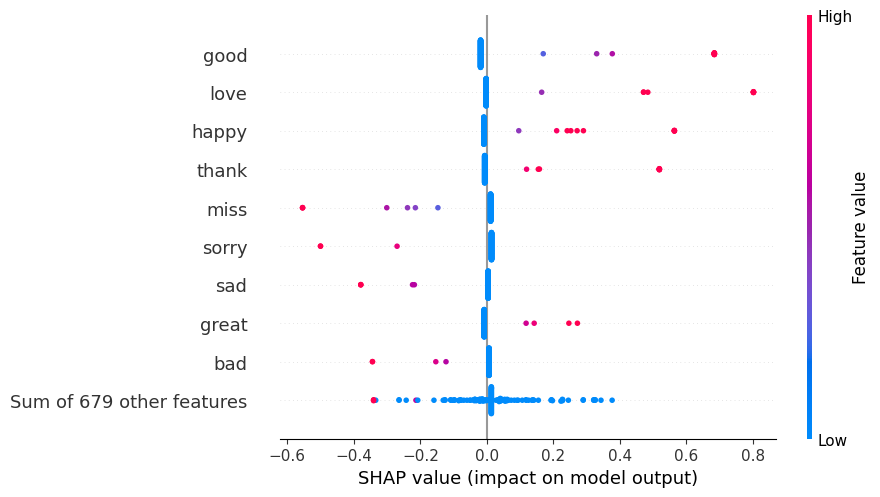

In [13]:
shap.plots.beeswarm(shap_values)

In [42]:
sentence = "Despite the initial confusion caused by the unclear instructions, the participants Eventually managed to adapt and thoroughly enJoyedd the well organized event."
sentence_processed = preprocess_text(sentence)
print(sentence_processed)

despite initial confusion cause unclear instruction participant eventually manage adapt thoroughly enjoy well organize event


In [43]:
model.predict(vectorizer.transform([sentence_processed]))[0]

'positive'

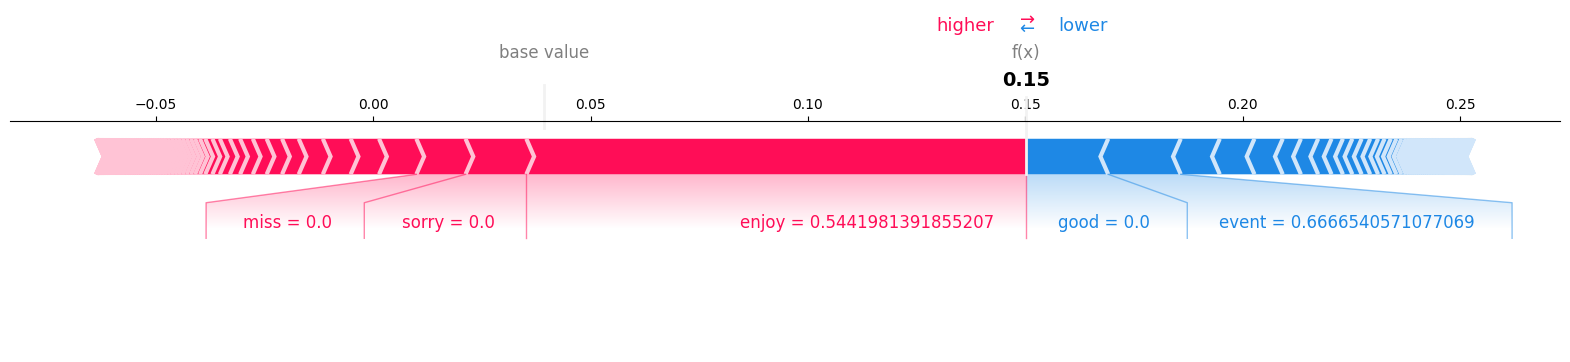

In [44]:
sentence_vectorized = vectorizer.transform([sentence_processed]).toarray()
shap_values = explainer(sentence_vectorized)
shap.plots.force(shap_values[0],matplotlib=True)